In [1]:
from __future__ import print_function, division
import os
import glob
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import cv2
import torchvision.models as models
from torchvision import transforms, utils
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.autograd import Variable
from tqdm import tqdm
from torch.optim import lr_scheduler
import copy
import PIL
import argparse
import random
import Augmentor
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt



# parser = argparse.ArgumentParser(description='Lane_detection_using_pretrained_resnet18')
# parser.add_argument('--batch_size', type=int, default=4, metavar='B',
#                     help='input batch size for training (default: 4)')
# parser.add_argument('--test_batch_size', type=int, default=4, metavar='TB',
#                     help='input batch size for testing (default: 4)')
# parser.add_argument('--epochs', type=int, default=10, metavar='E',
#                     help='number of epochs to train (default: 10)')
# parser.add_argument('--lr', type=float, default=0.006, metavar='LR',
#                     help='learning rate (default: 0.006)')

# parser.add_argument('--valid_set_size', type=float, default=0.4, metavar='VSS',
#                     help='validation set size (default: 0.4 so 4 % of all the batchs)')


# parser.add_argument('--rot', type=int, default=0, metavar='RO',
#                     help='1 for augmentation by rotation')
# #setting Blurring for default augmentation
# parser.add_argument('--gb', type=int, default=1, metavar='GB',
#                     help='1 for augmentation by Gaussian Blurring')

# parser.add_argument('--spk', type=int, default=0, metavar='SN',
#                     help='1 for augmentation by Speckle Noise')

# parser.add_argument('--isw', type=int, default=0, metavar='ISW',
#                     help='1 for augmentation by Image Segmentation using watershed')

# parser.add_argument('--shr', type=int, default=0, metavar='SH',
#                     help='1 for augmentation by Shear')



# parser.add_argument('--prob', type=float, default=0.5, metavar='PR',
#                     help='Enter value between 0 and 1 for the probability by which augmentation is performed')


# parser.add_argument('--noaug', type=int, default=1, metavar='NA',
#                     help='Enter 0 for no Augmentation at all')




LATENT_DIM = 5 #size of the latent space in the variational autoencoder
BATCH_SIZE = 128

In [2]:
# helper function for displaying images

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
class KittiDataset(Dataset):
    def __init__(self, directory, augment = False, transform=True):
        directory = directory + "/*.png"
        self.img_names = list(glob.glob(directory))
        # print (self.img_names)
        self.transform = transform
        self.augment = augment
        # self.p = Augmentor.Pipeline(directory)
        # self.p.random_distortion(probability=1, grid_width=4, grid_height=4, magnitude=8)
        # self.p.flip_left_right(probability=0.5)
        # self.p.flip_top_bottom(probability=0.5)


    def __len__(self):
        return len(self.img_names)

    def __getitem__(self,idx):
#         args = parser.parse_args()

        path = self.img_names[idx]
        image = cv2.imread(path)
#         print ("epoch")

        newHeight = 1200
        newWidth = 300
        # oldHeight = image.shape[0]
        # oldWidth = image.shape[1]
        # r = newHeight / oldHeight
        # newWidth = int(oldWidth * r)
        dim = (newHeight, newWidth)
        image = cv2.resize(image, dim,3, interpolation = cv2.INTER_AREA)
        # image = image.transpose(1,3)
        image_label = 0
        # print ("works")
        if 'uu_' in path:
            image_label = 0
        elif 'umm_' in path:
            image_label = 1
        elif 'um_' in path:
            image_label = 2
        else:
            print (" error in label")
            image_label = 2
#         if self.augment:

#             prob = args.prob

#             if prob <0 or prob >1:
#                 prob =0.5

#             #rotation of image 
#             row,col,ch = 1200,300,3
#             cv2.imwrite('image.png',image)
#             if args.rot == 1 and np.random.uniform(0,1) > prob:
#                 angle = random.randint(1,80)
#                 M = cv2.getRotationMatrix2D((300/2,1200/2),angle,1)
#                 image = cv2.warpAffine(image.copy(),M,(300,1200))
#             """*********************************************"""
#             if args.gb == 1 and np.random.uniform(0,1) > prob:
#             #Gaussian Blurring

#                 image = cv2.GaussianBlur(image,(5,5),0)


#             """*********************************************"""
#             #Segmentation algorithm using watershed
#             if args.isw == 1 and np.random.uniform(0,1) > prob:

#                 gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
#                 ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
#                 # noise removal
#                 kernel = np.ones((3,3),np.uint8)
#                 opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
#                 # sure background area
#                 sure_bg = cv2.dilate(opening,kernel,iterations=3)
#                 # Finding sure foreground area
#                 dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
#                 ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
#                 # Finding unknown region
#                 sure_fg = np.uint8(sure_fg)
#                 unknown = cv2.subtract(sure_bg,sure_fg)
#                 # Marker labelling
#                 ret, markers = cv2.connectedComponents(sure_fg)
#                 # Add one to all labels so that sure background is not 0, but 1
#                 markers = markers+1
#                 # Now, mark the region of unknown with zero
#                 markers[unknown==255] = 0

#                 markers = cv2.watershed(image,markers)
#                 image[markers == -1] = [255,0,0]
#                 cv2.imwrite('Segmentation.png',image)

#             """*********************************************"""

#             #speckle noise

#             if args.spk == 1 and np.random.uniform(0,1) > prob:
#                 row,col,ch = 1200,300,3
#                 gauss = np.random.randn(row,col,ch)
#                 gauss = gauss.reshape(row,col,ch)        
#                 image = image + image * gauss



#             #HOG descriptor of a image

#             # hog = cv2.HOGDescriptor()
#             # image = hog.compute(image)

#             #Shear transformation
#             if args.shr == 1 :

#                 pts1 = np.float32([[5,5],[20,5],[5,20]])

#                 pt1 = 5+10*np.random.uniform()-10/2
#                 pt2 = 20+10*np.random.uniform()-10/2
#                 pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])
#                 shear = cv2.getAffineTransform(pts1,pts2)

#                 image = cv2.warpAffine(image,shear,(col,row))
#                 cv2.imwrite('shear.png',image)


        if self.transform:
            self.transform = transforms.Compose(
                   [transforms.Resize((224,224)),
                    # p.torch_transform(),
                    transforms.ToTensor(),
                    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                    ])


            image = self.transform(PIL.Image.fromarray(image))

        dictionary  ={}

        # print (image.shape)
        dictionary["image"] = np.array(image,dtype = float)
        dictionary["label"] = float(image_label)
        return dictionary





In [3]:
class VAE_simple(nn.Module):
    def __init__(self):
        super(VAE_simple, self).__init__()

        self.fc1 = nn.Linear(3*224*224, 400)
        self.extra_layer = nn.Linear(400, 100)
        self.extra_layer2 = nn.Linear(100, 100)
        self.fc21 = nn.Linear(100, LATENT_DIM)
        self.fc22 = nn.Linear(100, LATENT_DIM)
        
        self.fc3 = nn.Linear(LATENT_DIM, 100)
        self.extra_layer_dec = nn.Linear(100, 100)
        self.extra_layer_dec2 = nn.Linear(100, 400)
        self.fc4 = nn.Linear(400, 3*224*224)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        h1 = self.relu(self.extra_layer(h1))
        h1 = self.relu(self.extra_layer2(h1))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        h3 = self.relu(self.extra_layer_dec(h3))
        h3 = self.relu(self.extra_layer_dec2(h3))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 3*224*224))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [4]:
def loss_function(reconstruced_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(reconstruced_x.view(-1, 3*224*224), x.view(-1, 3*224*224))

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # Normalise by same number of elements as in reconstruction
    KLD /= BATCH_SIZE * (3*224*224)

    return BCE + KLD

In [5]:
# my_transform = Compose([ToTensor(), 
#                         ToPILImage(), 
#                         Resize((28,28)), 
#                         ToTensor()])
train_directory ='data_road/training/image_2'
test_directory = 'data_road/testing/image_2'
train_set = KittiDataset(directory = train_directory, augment = False)
correct_count = 0

train_loader = DataLoader(train_set, batch_size=4, shuffle=True, num_workers=0)

# train_set = ImageFolder(root='train_set', transform=my_transform) #loading images from folder and resize them to 28x28
# train_loader = DataLoader(train_set, batch_size=128, shuffle=True)

In [6]:
net = VAE_simple()
optimizer = optim.Adam(net.parameters())

In [7]:
net.train() #set the model in the training mode (important for Dropout and BatchNorm)
NUMBER_OF_IMAGES = len(train_loader)
print ("hi")
for epoch in range(50):  # loop over the dataset multiple times
    print (epoch)
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        # get the inputs
        inputs, labels = data['image'].view(len(data["label"]),3,224,224).float(),data['label'].float()
        
        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        reconstructed_batch, mu, logvar = net(inputs)
        
        outputs = net(inputs)
        loss = loss_function(reconstructed_batch, inputs, mu, logvar)
        loss.backward()
        optimizer.step()
        running_loss += loss.data[0]*inputs.size(0)

    print('Epoch %d, loss: %.3f' % (epoch + 1, running_loss / NUMBER_OF_IMAGES))
                
print('Finished Training')

hi
0
Epoch 1, loss: 2.453
1
Epoch 2, loss: 2.325
2
Epoch 3, loss: 2.283
3
Epoch 4, loss: 2.252
4
Epoch 5, loss: 2.280
5
Epoch 6, loss: 2.220
6
Epoch 7, loss: 2.200
7
Epoch 8, loss: 2.189
8
Epoch 9, loss: 2.188
9
Epoch 10, loss: 2.187
10
Epoch 11, loss: 2.170
11
Epoch 12, loss: 2.164
12
Epoch 13, loss: 2.157
13
Epoch 14, loss: 2.163
14
Epoch 15, loss: 2.168
15
Epoch 16, loss: 2.151
16
Epoch 17, loss: 2.143
17
Epoch 18, loss: 2.139
18
Epoch 19, loss: 2.141
19
Epoch 20, loss: 2.161
20
Epoch 21, loss: 2.138
21
Epoch 22, loss: 2.133
22
Epoch 23, loss: 2.119
23
Epoch 24, loss: 2.121
24
Epoch 25, loss: 2.119
25
Epoch 26, loss: 2.111
26
Epoch 27, loss: 2.134
27
Epoch 28, loss: 2.149
28
Epoch 29, loss: 2.135
29
Epoch 30, loss: 2.125
30
Epoch 31, loss: 2.108
31
Epoch 32, loss: 2.095
32
Epoch 33, loss: 2.098
33
Epoch 34, loss: 2.094
34
Epoch 35, loss: 2.105
35
Epoch 36, loss: 2.084
36
Epoch 37, loss: 2.083
37
Epoch 38, loss: 2.071
38
Epoch 39, loss: 2.074
39
Epoch 40, loss: 2.073
40
Epoch 41, los

# Evaluation
Let's see how our autoencoder reconstructs given images

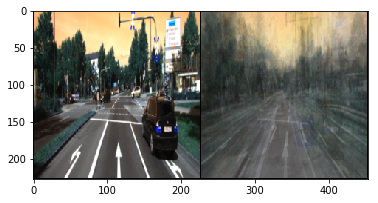

In [22]:
net.eval()
images = [0,0]
image =train_loader.dataset[100]
image = torch.from_numpy(image['image']).view(3,224,224).float()
output = net(Variable(image.unsqueeze(0)))
plt.show(output)
images[0] = image #original image
images[1] = output[0].data.view(3,224,224) # reconstructed image
imshow(torchvision.utils.make_grid(images))

In [ ]:
output = net(Variable(train_loader.dataset[3000][0].unsqueeze(0)))
images[0] = train_loader.dataset[3000][0] #original image
images[1] = output[0].data.view(3,224,224) # reconstructed image
imshow(torchvision.utils.make_grid(images))

In [ ]:
output = net(Variable(train_loader.dataset[2500][0].unsqueeze(0)))
images[0] = train_loader.dataset[2500][0] #original image
images[1] = output[0].data.view(3,224,224) # reconstructed image
imshow(torchvision.utils.make_grid(images))

# Generating images

Now we generate images from random samples taken from normal distribution

In [ ]:
# let's generate 104 images and save it in 13x8 grid
sample = Variable(torch.randn(104, LATENT_DIM))
sample = net.decode(sample)
fig = plt.figure(figsize=(20,20))
imshow(torchvision.utils.make_grid(sample.data.view(104, 3, 224, 224)))